# AIMS CDT: Machine Learning Assignment
Implementation of a neural network "from scratch".

## Import the required libraries and modules

Display a few random items

In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random, math


## Import the MNIST dataset

Display a few random items

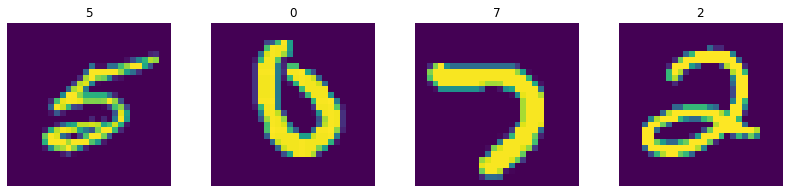

In [2]:
import random

class Dataset(object):
    
    def __init__(self, dataset, N):

        # Create matrix where columns are images
        self.features = torch.zeros(28*28, N)
        self.classes = torch.zeros(N, dtype=torch.int8)
        self.targets = torch.zeros(10, N, dtype=torch.int8)
        
        # Randomly sample N items from the full dataset
        for i, j in enumerate(random.sample(list(range(len(dataset.data))), N)):

            d = dataset.data[j]

            # Flattened image and class
            img = d.view(-1, 28*28)
            target = dataset[j][1]
            # print(target, img)

            self.features[:, i] = img / 255.0
            self.classes[i] = target
            self.targets[target, i] = 1

            if i == N-1:
                break

    def __len__(self):
        return len(self.targets)

# Display a random sample of k images
k = 4
mnist = datasets.MNIST('../data', train=True, download=True)
data = Dataset(mnist, k)

fig, ax = plt.subplots(1, k, figsize=(3.5*k, 3))
for i in range(k):
    ax[i].axis('off')
    ax[i].set_title(int(data.classes[i]))
    ax[i].imshow(data.features[:, i].view(28,28)) # un-flatten

plt.show()



## Core implementation classes

In [3]:

class Activation(object):

    def __init__(self, f='sigmoid'):

        if f == 'sigmoid':
            self.func = self.sigmoid

        elif f == 'relu':
            self.func = self.relu
        
        elif f == 'tanh':
            self.func = self.tanh

        # Default to sigmoid
        else:
            self.func = self.sigmoid

    def __call__(self, x):
        '''
        Compute the activation.
        '''
        return self.func(x) 

    def sigmoid(self, x): 
        '''
        Sigmoid activation.
        '''
        return 1/(1+torch.exp(-x))

    def tanh(self, x): 
        '''
        tanh activation.
        (NOTE: not working for some reason)
        '''
        return (torch.exp(2*x) - 1)/(torch.exp(2*x) + 1)

    def relu(self, x): 
        '''
        ReLU activation.
        (NOTE: not working for some reason)
        '''
        return torch.clamp(x,0)


class Loss(object):

    def __init__(self, f='crossentropy'):
        if f == 'crossentropy':
            self.func = self.cross_entropy

        # Default value
        else:
            self.func = self.cross_entropy

    def cross_entropy(self, y_pred, y_true):
        '''
        Cross entropy for prediction probabilities x
        and true classes y.
        '''
        N = y_pred.shape[1]
        loss = - torch.sum(y_true * torch.log2(y_pred)) / N

        return loss


    def __call__(self, y_pred, y_true):
        return self.func(y_pred, y_true)


class NeuralNetwork(object):

    def __init__(self, layers, iter=100, learning_rate=1e-4, activation='relu'):

        # TODO: add bias term
        self.layers = []
        self.weights = []
        self.biases = []
        self.rate = learning_rate
        self.iter = iter

        self.create_network(layers)

        self.activation = Activation(activation)

    def create_network(self, layers):
        '''
        Build the layers of the network (weights and biases).
        '''

        # Create layers
        for L in layers:
            self.layers.append(torch.zeros(L, 1))

        # Create weights
        for i in range(len(layers) - 1):
            # Li is nx1, Lj is mx1 where j=i+1
            # wij is m x n 
            n, m = layers[i], layers[i+1]
            
            # Weight matrices
            # Initialised by sampling from standard normal
            # Require gradients to be computed for autograd
            self.weights.append(torch.randn(m, n, requires_grad=True))
            self.biases.append(torch.randn(1, 1, requires_grad=True))

    def forward(self, sig):
        '''
        Propagate signal forward through network.
        '''
        out = sig

        for i in range(len(self.weights)):
            out =  self.weights[i] @ out + self.biases[i]

            # Activation function (default: ReLU) on hidden layers
            if i < len(self.weights) - 1:
                out = self.activation(out)

        # Softmax function on output layer
        out = torch.softmax(out, 0)
        return out

    def predict(self, sig):
        '''
        Compute the prediction on the ourelu
        '''
        return torch.argmax(self.forward(sig), 0)


In [4]:
# Load sample from dataset for training
N_train = 8192
mnist_train = datasets.MNIST('../data', train=True, download=True)
data_train = Dataset(mnist_train, N_train)

# Test data
N_test = 8192
mnist_test = datasets.MNIST('../data', train=False, download=True)
data_test = Dataset(mnist_test, N_test)

# Create neural network
layers = [784, 128, 64, 10]
nn = NeuralNetwork(layers, 
    activation='sigmoid')

# Training inputs and outputs
x_train = data_train.features
y_train = data_train.classes
x_test = data_test.features
y_test = data_test.classes

# Training loop parameters
iterations = 400
learning_rate = 1
batch_size = 128
num_batches = math.ceil(N_train / batch_size)

# Loss function
compute_loss = Loss('crossentropy')

# Stored histories
it_history = []
loss_history = [] # training loss
training_history = []
test_history = []

# Training loop
for i in range(iterations+1):

    # Compute metrics on regular intervals
    if i % 5 == 0:

        # Training set accuracy and loss
        y_pred_train = nn.predict(x_train)
        correct = torch.sum(y_pred_train == y_train).item()
        acc_train = float(correct) / len(y_pred_train) * 100
        loss = compute_loss(nn.forward(x_train), data_train.targets)

        # Test set accuracy
        y_pred_test = nn.predict(x_test)
        correct = torch.sum(y_pred_test == y_test).item()
        acc_test = float(correct) / len(y_pred_test) * 100

        # Printouts
        # print('Iteration {:4d} - training accuracy {:.2f}%'.format(i, acc_train))
        print('Iteration {:4d} - test accuracy {:.2f}%'.format(i, acc_test))

        # Store accuracies
        training_history.append(acc_train)
        test_history.append(acc_test)
        it_history.append(i)
        loss_history.append(loss.item())

    # Train using gradient descent in mini-batches
    for b in range(num_batches):

        # Batch start and end indices
        i1 = b * batch_size
        i2 = min(i1 + batch_size, N_train)
        y_pred = nn.forward(x_train[:, i1:i2])
        y_true = data_train.targets[:, i1:i2]

        # Compute loss
        loss = compute_loss(y_pred, y_true)

        # Backward pass
        loss.backward()

        # Apply backward update
        with torch.no_grad():
            for j in reversed(range(len(nn.weights))):
                
                # Update weights (incl. biases) via gradient descent
                nn.weights[j].sub_(learning_rate * nn.weights[j].grad)
                nn.biases[j].sub_(learning_rate * nn.biases[j].grad)

                # Reset stored gradients
                nn.weights[j].grad.data.zero_()
                nn.biases[j].grad.data.zero_()



print('\n\nTraining completed after {:d} iterations.'.format(iterations))




Iteration    0 - test accuracy 10.23%
Iteration    5 - test accuracy 84.66%
Iteration   10 - test accuracy 86.96%
Iteration   15 - test accuracy 87.98%
Iteration   20 - test accuracy 88.31%
Iteration   25 - test accuracy 88.83%
Iteration   30 - test accuracy 89.07%
Iteration   35 - test accuracy 89.31%
Iteration   40 - test accuracy 89.48%
Iteration   45 - test accuracy 89.58%
Iteration   50 - test accuracy 89.66%
Iteration   55 - test accuracy 89.71%
Iteration   60 - test accuracy 89.76%
Iteration   65 - test accuracy 89.79%
Iteration   70 - test accuracy 89.84%
Iteration   75 - test accuracy 89.83%
Iteration   80 - test accuracy 89.87%
Iteration   85 - test accuracy 89.94%
Iteration   90 - test accuracy 89.94%
Iteration   95 - test accuracy 89.95%
Iteration  100 - test accuracy 89.99%
Iteration  105 - test accuracy 90.05%
Iteration  110 - test accuracy 90.09%
Iteration  115 - test accuracy 90.09%
Iteration  120 - test accuracy 90.06%
Iteration  125 - test accuracy 90.08%
Iteration  1

## Training loss

Plot the cross-entropy on the training data over the full training cycle. 

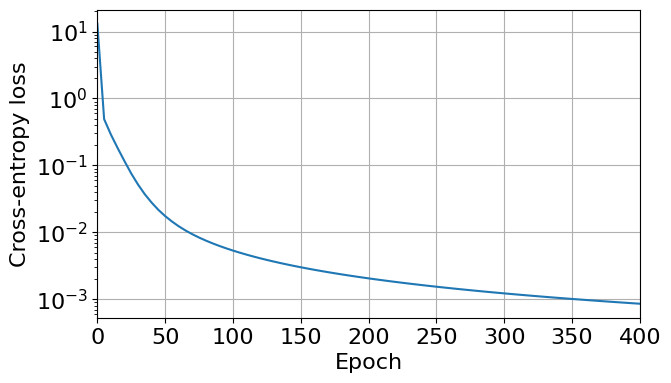

In [5]:
from pylab import rcParams
from matplotlib import rcParamsDefault

rcParams.update(rcParamsDefault)
rcParams['figure.figsize'] = 7,4
rcParams.update({'font.size': 16})

# Training loss 
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Cross-entropy loss')
plt.xlim([0, iterations])
plt.yscale('log')
plt.plot(it_history, loss_history)
plt.show()

## Confusion matrix

Plot the confusion matrix for the predictions on the test set after training is completed. 

Text(24.75, 0.5, 'True class')

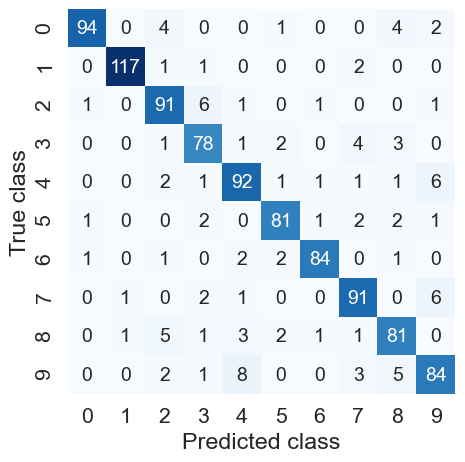

In [6]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
%matplotlib inline
import numpy as np
import matplotlib

rcParams.update(rcParamsDefault)
rcParams['figure.figsize'] = 5,5

# Limit number of samples shown in confusion matrix
lim = 1000 

# Compute the matrix
confusion = np.zeros((10, 10), dtype=np.int32)
for i in range(N_test):
    pred, true = y_pred_test[i].item(), y_test[i].item()
    confusion[pred, true] += 1
    if i == lim: break

# Plotting
df_cm = pd.DataFrame(confusion, range(10), range(10))
sn.set(font_scale=1.4) # for label size
ax = plt.axes()
sn.heatmap(df_cm, ax=ax, annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={"size": 14}) # font size
ax.set_xlabel('Predicted class')
ax.set_ylabel('True class')


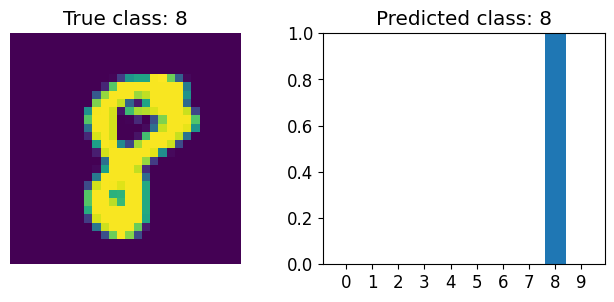

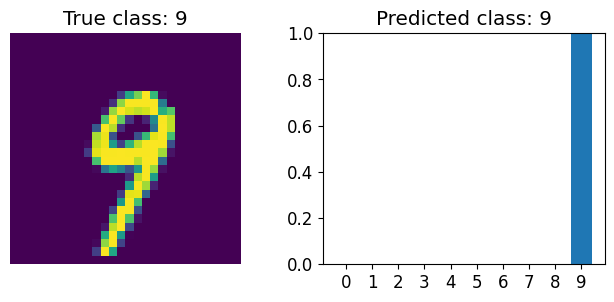

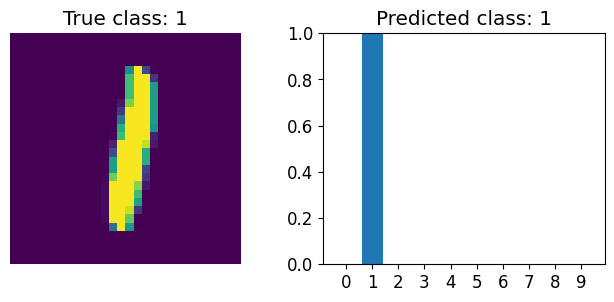

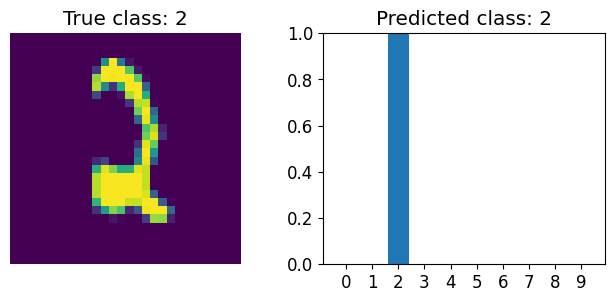

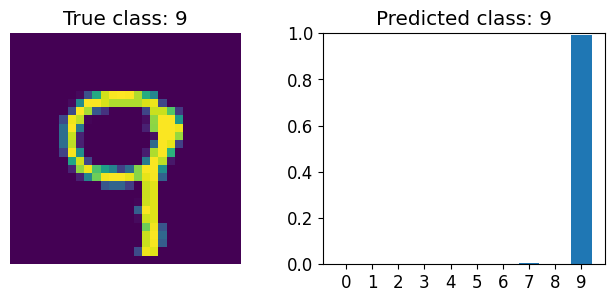

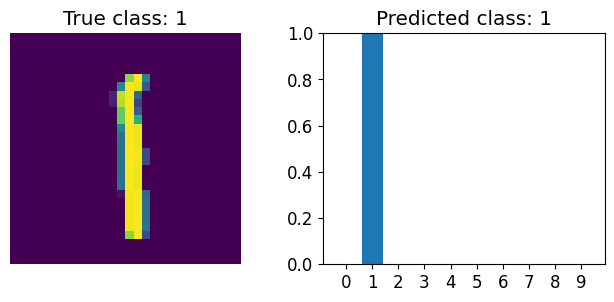

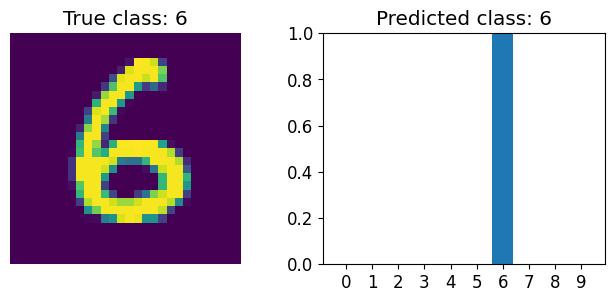

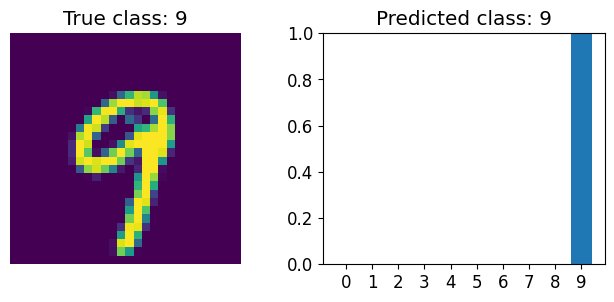

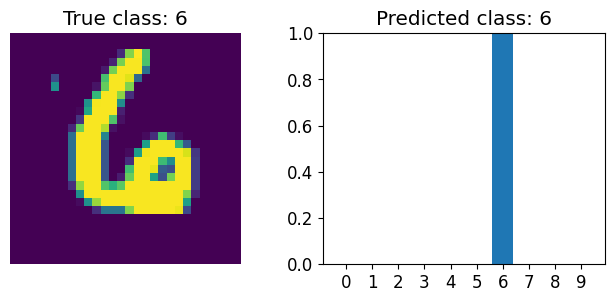

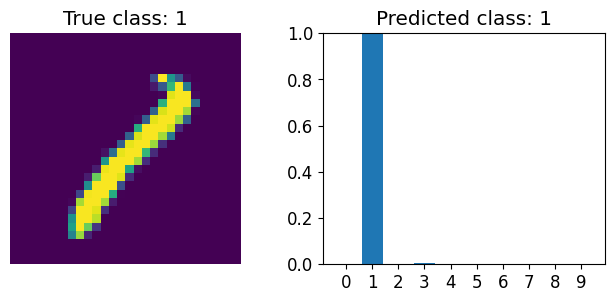

In [7]:
rcParams.update(rcParamsDefault)
rcParams.update({'font.size': 12})

# Sample a few test data items for plotting
k = 10
data_display = Dataset(mnist_test, k)
x_display = data_display.features
y_pred = nn.forward(x_display)

# Plotting
for i in range(k):
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))

    ax[0].axis('off')
    ax[0].set_title('True class: ' + str(int(data_display.classes[i])))
    ax[0].imshow(data_display.features[:, i].view(28,28), cmap='viridis') # un-flatten

    ax[1].bar(range(10), y_pred[:,i].detach().numpy())
    pred = torch.argmax(y_pred[:,i]).item()
    ax[1].set_title('Predicted class: ' + str(pred))
    ax[1].set_ylim((0,1))
    plt.xticks(range(10))

plt.show()